In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import dataset

dataset = dataset.HDFDataset(
    hdf_file_path="/root/data/dataset_prep/faze_preprocess/outputs_sted/GazeCapture.h5",
    get_2nd_sample=True
)

dataloader = DataLoader(
    dataset,
    batch_size=6,
    shuffle=True,
    num_workers=4
)

In [2]:
import dnnlib
import legacy
with dnnlib.util.open_url('pretrained/stylegan3-r-ffhqu-256x256.pkl') as f:
        Generator = legacy.load_network_pkl(f)['G_ema'].eval()
        Generator.requires_grad_(False)

In [4]:
# check layers
print(Generator)

Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=16,
    img_resolution=256, img_channels=3,
    num_layers=14, num_critical=2,
    margin_size=10, num_fp16_res=4
    (input): SynthesisInput(
      w_dim=512, channels=1024, size=[36, 36],
      sampling_rate=16, bandwidth=2
      (affine): FullyConnectedLayer(in_features=512, out_features=4, activation=linear)
    )
    (L0_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_cutoff=2,
      in_half_width=6, out_half_width=6,
      in_size=[36, 36], out_size=[36, 36],
      in_channels=1024, out_channels=1024
      (affine): FullyConnectedLayer(in_features=512, out_features=1024, activation=linear)
    )
    (L1_36_1024): SynthesisLayer(
      w_dim=512, is_torgb=False,
      is_critically_sampled=False, use_fp16=False,
      in_sampling_rate=16, out_sampling_rate=16,
      in_cutoff=2, out_c

In [31]:
x_dummy = torch.randn(1, 16, 512)
x_dummy.unbind(dim=1)

16

In [35]:
Generator = Generator.to("cuda")
x_dummy = torch.randn(1, 16, 512).to("cuda")
ws = x_dummy.unbind(dim=1)

x = Generator.synthesis.input(ws[0])
print(f"input layer out: {x.shape}") # first slice of the input tensor
for name, w in zip(Generator.synthesis.layer_names, ws[1:]):
    x = getattr(Generator.synthesis, name)(x, w)
    print(f"{name} out: {x.shape}")
if Generator.synthesis.output_scale != 1:
    x = x * Generator.synthesis.output_scale

print(f"output layer out: {x.shape}")

input layer out: torch.Size([1, 1024, 36, 36])
L0_36_1024 out: torch.Size([1, 1024, 36, 36])
L1_36_1024 out: torch.Size([1, 1024, 36, 36])
L2_36_1024 out: torch.Size([1, 1024, 36, 36])
L3_52_1024 out: torch.Size([1, 1024, 52, 52])
L4_52_1024 out: torch.Size([1, 1024, 52, 52])
L5_84_1024 out: torch.Size([1, 1024, 84, 84])
L6_84_1024 out: torch.Size([1, 1024, 84, 84])
L7_148_724 out: torch.Size([1, 724, 148, 148])
L8_148_512 out: torch.Size([1, 512, 148, 148])
L9_148_362 out: torch.Size([1, 362, 148, 148])
L10_276_256 out: torch.Size([1, 256, 276, 276])
L11_276_181 out: torch.Size([1, 181, 276, 276])
L12_276_128 out: torch.Size([1, 128, 276, 276])
L13_256_128 out: torch.Size([1, 128, 256, 256])
L14_256_3 out: torch.Size([1, 3, 256, 256])
output layer out: torch.Size([1, 3, 256, 256])


In [39]:
dataset[0]['image_a'].shape

torch.Size([3, 128, 128])

2023-05-12 03:19:25,441 Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input layer out: torch.Size([1, 1024, 36, 36])
L0_36_1024 out: torch.Size([1, 1024, 36, 36])
L1_36_1024 out: torch.Size([1, 1024, 36, 36])
L2_36_1024 out: torch.Size([1, 1024, 36, 36])
L3_52_1024 out: torch.Size([1, 1024, 52, 52])
L4_52_1024 out: torch.Size([1, 1024, 52, 52])
L5_84_1024 out: torch.Size([1, 1024, 84, 84])
L6_84_1024 out: torch.Size([1, 1024, 84, 84])
L7_148_724 out: torch.Size([1, 724, 148, 148])
L8_148_512 out: torch.Size([1, 512, 148, 148])
L9_148_362 out: torch.Size([1, 362, 148, 148])
L10_276_256 out: torch.Size([1, 256, 276, 276])
L11_276_181 out: torch.Size([1, 181, 276, 276])
L12_276_128 out: torch.Size([1, 128, 276, 276])
L13_256_128 out: torch.Size([1, 128, 256, 256])
L14_256_3 out: torch.Size([1, 3, 256, 256])
output layer out: torch.Size([1, 3, 256, 256])


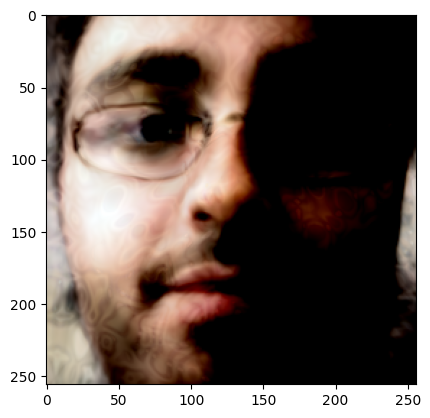

In [46]:
# integerity check
from models.inversion_encoder import networks_encoder as inversion_encoder
E = inversion_encoder.Encoder(pretrained="pretrained/inversion_encoder_snapshot_100000.pkl", w_avg=None)
E = E.to("cuda")
from torchvision import transforms
import matplotlib.pyplot as plt
t_256 = transforms.Resize((256, 256), antialias=True)
test_latent = E(t_256(dataset[0]['image_a'].to("cuda").unsqueeze(0)))

ws = test_latent.unbind(dim=1)

x = Generator.synthesis.input(ws[0])

print(f"input layer out: {x.shape}") # first slice of the input tensor
for name, w in zip(Generator.synthesis.layer_names, ws[1:]):
    x = getattr(Generator.synthesis, name)(x, w)
    print(f"{name} out: {x.shape}")
if Generator.synthesis.output_scale != 1:
    x = x * Generator.synthesis.output_scale

print(f"output layer out: {x.shape}")
plt.imshow(x.detach().cpu().squeeze(0).to(torch.float32).permute(1, 2, 0).numpy())

In [51]:
query = torch.rand(16, 4, 200, device="cuda")
key_val = torch.rand(16, 4, 100, device="cuda")
attn = nn.MultiheadAttention(200, 2, kdim=100, vdim=100).to("cuda")
out, _ = attn(query, key_val, key_val)
out.shape

torch.Size([16, 4, 200])

In [3]:
from models.redirect_net import RedirectNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedirectNet().to(device)
model.eval()


for name, module in model.named_modules():
    if name.startswith('gaze_head_mapping') or name.startswith('latent_entry') or name.startswith('latent_exit') or name.startswith('up') or name.startswith('down'):
        # init weights 
        for sub_module in module.modules():
            # if linear
            if isinstance(sub_module, nn.Linear):
                #nn.init.eye_(sub_module.weight)
                #nn.init.zeros_(sub_module.bias)
                pass

test_batch = next(iter(dataloader))
x_a = test_batch['image_a'].to(device)
x_b = test_batch['image_b'].to(device)

with torch.no_grad():
    out_dict = model(x_a, x_b)



Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


(-0.5, 1535.5, 767.5, -0.5)

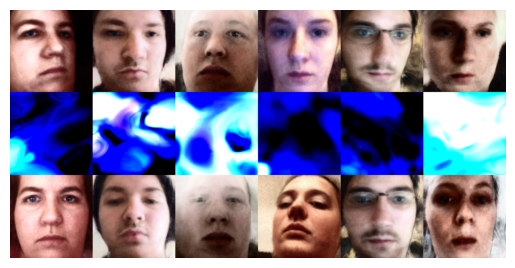

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
def return_image(images, gh, gw, H, W):
    np_imgs = []
    for i, image in enumerate(images):
        image = images[i][None,:,:]
        image = (image.permute(0,2,3,1)*127.5+128).clamp(0,255).to(torch.uint8).cpu().numpy()
        np_imgs.append(np.asarray(PIL.Image.fromarray(image[0], 'RGB').resize((H,W),PIL.Image.LANCZOS)))
    np_imgs = np.stack(np_imgs)
    np_imgs = np_imgs.reshape(gh,gw,H,W,3)
    np_imgs = np_imgs.transpose(0,2,1,3,4)
    np_imgs = np_imgs.reshape(gh*H, gw*W, 3)
    return np_imgs

plt.imshow(return_image(torch.cat(
    (out_dict['id_reference'], out_dict['image_pred'], out_dict['image_target']),
    dim=0
), 3, 6, 256, 256))
plt.axis('off')

In [5]:
out_dict.keys()

dict_keys(['latent_pred', 'latent_target', 'gaze_pred', 'head_pose_pred', 'gaze_target', 'head_pose_target', 'image_pred', 'image_target', 'id_reference', 'latent_reference'])

In [6]:
class CrossAttention(nn.Module):
    def __init__(self, in_channels_q, in_channels_kv, out_channels, num_heads, dropout=0.2):
        super().__init__()
        self.query = nn.Linear(in_channels_q, out_channels)
        self.key_value = nn.Linear(in_channels_kv, out_channels * 2)
        self.attention = nn.MultiheadAttention(out_channels, num_heads, dropout=dropout)
        
    def forward(self, x_query, x_key_value):
        B_q, C_q, H_q, W_q = x_query.size()
        B_kv, C_kv, H_kv, W_kv = x_key_value.size()
        
        query = self.query(x_query.view(B_q, C_q, -1).permute(2, 0, 1))
        print(f"torch.max(query): {torch.max(query)}, torch.min(query): {torch.min(query)}")
        key_value = self.key_value(x_key_value.view(B_kv, C_kv, -1).permute(2, 0, 1))
        print(f"torch.max(key_value): {torch.max(key_value)}, torch.min(key_value): {torch.min(key_value)}")
        key, value = torch.chunk(key_value, 2, dim=-1)
        
        out, _ = self.attention(query, key, value)
        #print(out.shape)
        return out.permute(1, 2, 0).view(B_q, C_q, H_q, W_q)
cross_attention = CrossAttention(512, 512, 512, 4).to(device)
cross_attention.eval()

for name, module in cross_attention.named_modules():
    # init weights as identity
    if isinstance(module, nn.Linear):
        print(f"init {name} as identity")
        #nn.init.eye_(module.weight)
        #nn.init.zeros_(module.bias)


init query as identity
init key_value as identity
init attention.out_proj as identity


torch.max(query): 297618.96875, torch.min(query): -359426.21875
torch.max(key_value): 1.5763074159622192, torch.min(key_value): -2.012697219848633


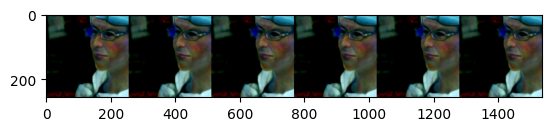

In [9]:
gaze_mapped = torch.ones(6, 512, 1, 1).to(device)
latent_source = out_dict['latent_reference'].permute(0, 2, 1).view(6, 512, 4, 4).to(device)
Generator = Generator.to(device)
with torch.no_grad():
    out_ca = cross_attention(latent_source, gaze_mapped)

plt.imshow(return_image(Generator.synthesis(out_ca.view(6, 512, 16).permute(0, 2, 1)), 1, 6, 256, 256))

In [27]:
torch.max(latent_source)


tensor(1163567.8750, device='cuda:0')

In [46]:
torch.max(out_ca), torch.min(out_ca)

(tensor(0.6388, device='cuda:0'), tensor(-0.5817, device='cuda:0'))

In [7]:
class InvertedCrossAttention(nn.Module):
    def __init__(self,
                 in_channels_q, # query feature map W_q*H_q (used as seq_len)
                 in_channels_kv, # key/value feature map W_kv*H_kv (used as seq_len)
                 num_heads):
        super().__init__()
        self.query = nn.Linear(in_channels_q, in_channels_kv)
        self.key_value = nn.Linear(in_channels_kv, in_channels_kv * 2)
        self.attention = nn.MultiheadAttention(in_channels_kv, num_heads)

    def forward(self, x_query, x_key_value):
        B_q, C_q, H_q, W_q = x_query.size()
        B_kv, C_kv, H_kv, W_kv = x_key_value.size()
        query = self.query(x_query.view(B_q, C_q, -1).permute(1, 0, 2)) # (C_q, B_q, W_q*H_q)
        key_value = self.key_value(x_key_value.view(B_kv, C_kv, -1).permute(1, 0, 2)) # (C_kv, B_kv, W_kv*H_kv*2)
        key, value = torch.chunk(key_value, 2, dim=-1)
        out, _ = self.attention(query, key, value)
        return out.permute(1, 0, 2).view(B_kv, C_kv, H_kv, W_kv)

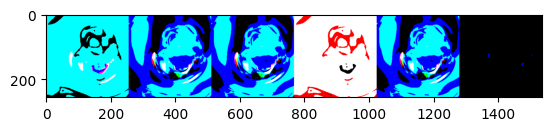

In [21]:
inv_at = InvertedCrossAttention(4, 16, 4).to(device)
inv_at.eval()

gaze_mapped = torch.ones(6, 512, 2, 2).to(device)
latent_source = out_dict['latent_reference'].permute(0, 2, 1).view(6, 512, 4, 4).to(device)

with torch.no_grad():
    out_inv_at = inv_at(gaze_mapped, latent_source)
Generator = Generator.to(device)
plt.imshow(return_image(Generator.synthesis(out_inv_at.view(6, 512, 16).permute(0, 2, 1).to(device)), 1, 6, 256, 256))

In [38]:
out_inv_at

tensor([[[[ 55801.4375,   2290.7969,   7165.3672,   9571.2510],
          [  9526.9609, -32873.7969, -26633.2344,  18976.9863],
          [ 42026.0781,  12511.9043,  -7077.4097,  18036.9297],
          [ 21262.7656, -16621.0371,   8572.3789, -12069.6025]],

         [[ 55801.4375,   2290.7969,   7165.3672,   9571.2510],
          [  9526.9609, -32873.7969, -26633.2344,  18976.9863],
          [ 42026.0781,  12511.9043,  -7077.4097,  18036.9297],
          [ 21262.7656, -16621.0371,   8572.3789, -12069.6025]],

         [[ 55801.4375,   2290.7969,   7165.3672,   9571.2510],
          [  9526.9609, -32873.7969, -26633.2344,  18976.9863],
          [ 42026.0781,  12511.9043,  -7077.4097,  18036.9297],
          [ 21262.7656, -16621.0371,   8572.3789, -12069.6025]],

         ...,

         [[ 55801.4375,   2290.7969,   7165.3672,   9571.2510],
          [  9526.9609, -32873.7969, -26633.2344,  18976.9863],
          [ 42026.0781,  12511.9043,  -7077.4097,  18036.9297],
          [ 21262.7